/tmp/ipykernel_10775/640721480.py:68: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(extract_dir)


✅ arn:aws:sagemaker:eu-central-1:078046068262:model-package/YOLOModelPackageGroup/29 → recall = 0.58544
✅ arn:aws:sagemaker:eu-central-1:078046068262:model-package/YOLOModelPackageGroup/28 → recall = 0.68
✅ arn:aws:sagemaker:eu-central-1:078046068262:model-package/YOLOModelPackageGroup/27 → recall = 0.64


/tmp/ipykernel_10775/640721480.py:105: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(extract_dir)


🏆 Selected model ARN: arn:aws:sagemaker:eu-central-1:078046068262:model-package/YOLOModelPackageGroup/28
recall = 0.68
Using model file: model_dir/train/weights/best.onnx
Loading model_dir/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime CPUExecutionProvider

image 1/1 /home/sagemaker-user/000000001000.jpg: 480x640 1 person, 95.1ms
Speed: 2.9ms preprocess, 95.1ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


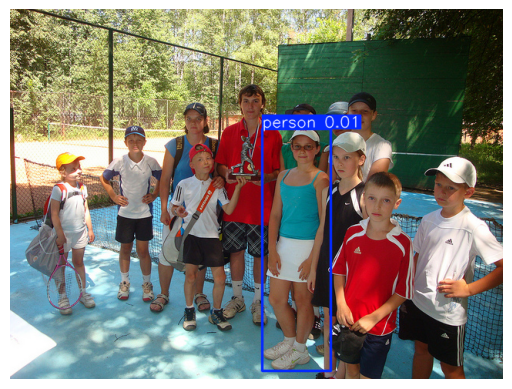

In [2]:
import boto3
import os
import tarfile
import json
import math
import shutil
from urllib.parse import urlparse
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt

MODEL_GROUP = "YOLOModelPackageGroup"
ONLY_APPROVED = False
METRIC_KEY = "recall"  # İstersen "map_50" yapabilirsin

def _parse_s3(s3_uri):
    u = urlparse(s3_uri)
    return u.netloc, u.path.lstrip("/")

def _object_exists(s3, bucket, key):
    try:
        s3.head_object(Bucket=bucket, Key=key)
        return True
    except:
        return False

def get_best_model_by_metric():
    sm = boto3.client("sagemaker")
    s3 = boto3.client("s3")

    args = {
        "ModelPackageGroupName": MODEL_GROUP,
        "SortBy": "CreationTime",
        "SortOrder": "Descending",
        "MaxResults": 50
    }
    if ONLY_APPROVED:
        args["ModelApprovalStatus"] = "Approved"

    best = {"metric": -math.inf, "model_s3": None, "arn": None}

    for pkg in sm.list_model_packages(**args)["ModelPackageSummaryList"]:
        desc = sm.describe_model_package(ModelPackageName=pkg["ModelPackageArn"])
        model_s3_uri = desc["InferenceSpecification"]["Containers"][0]["ModelDataUrl"]

        # Training job adını model S3 yolundan çıkar
        bucket, key = _parse_s3(model_s3_uri)
        parts = key.split("/")
        if len(parts) < 3:
            print(f"⚠️ Path format beklenmedik: {model_s3_uri}")
            continue
        training_job_name = parts[0]  # genelde ilk kısım training job adıdır
        output_key = f"{training_job_name}/output/output.tar.gz"

        # output.tar.gz var mı kontrol et
        if not _object_exists(s3, bucket, output_key):
            print(f"⚠️ output.tar.gz bulunamadı: s3://{bucket}/{output_key}")
            continue

        # output.tar.gz indir
        temp_out = "temp_output.tar.gz"
        s3.download_file(bucket, output_key, temp_out)

        # evaluation_metrics.json oku
        extract_dir = "temp_output_dir"
        os.makedirs(extract_dir, exist_ok=True)
        with tarfile.open(temp_out, "r:gz") as tar:
            tar.extractall(extract_dir)

        metric_val = None
        for root, dirs, files in os.walk(extract_dir):
            if "evaluation_metrics.json" in files:
                with open(os.path.join(root, "evaluation_metrics.json")) as f:
                    metrics_json = json.load(f)
                metric_val = metrics_json.get(METRIC_KEY)
                break

        shutil.rmtree(extract_dir, ignore_errors=True)
        os.remove(temp_out)

        if metric_val is None:
            print(f"⚠️ {METRIC_KEY} bulunamadı: {model_s3_uri}")
            continue

        print(f"✅ {pkg['ModelPackageArn']} → {METRIC_KEY} = {metric_val}")

        if math.isfinite(metric_val) and metric_val > best["metric"]:
            best = {
                "metric": metric_val,
                "model_s3": model_s3_uri,
                "arn": pkg["ModelPackageArn"]
            }

    if not best["model_s3"]:
        raise RuntimeError("No suitable model found.")

    # En iyi modeli indir
    b, k = _parse_s3(best["model_s3"])
    tar_path = "model.tar.gz"
    s3.download_file(b, k, tar_path)

    extract_dir = "model_dir"
    os.makedirs(extract_dir, exist_ok=True)
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(extract_dir)

    # ONNX dosyası bul
    onnx_path = None
    for root, dirs, files in os.walk(extract_dir):
        for file in files:
            if file.endswith(".onnx"):
                onnx_path = os.path.join(root, file)
                break

    if not onnx_path:
        raise RuntimeError("No ONNX file found.")

    return onnx_path, best["arn"], best["metric"]

# -------------------
# MAIN INFERENCE FLOW
# -------------------

model_path, best_model_arn, best_metric = get_best_model_by_metric()
print(f"🏆 Selected model ARN: {best_model_arn}")
print(f"{METRIC_KEY} = {best_metric}")
print(f"Using model file: {model_path}")

# YOLO modeli yükle
model = YOLO(model_path, task="detect")

# Test image
test_image_path = "000000001000.jpg"

# Inference
results = model(test_image_path, conf=0.0127)

# Save result
results[0].plot(save=True)

# Show inline
img = results[0].plot()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()
